In [1]:
import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product
from sklearn import model_selection as ms

%matplotlib inline

# Data pre-processing

Read in the *Child Health and Development Studies* data from the R package [`mosaicData`](https://cran.r-project.org/package=mosaicData).

In [2]:
gestation = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/mosaicData/Gestation.csv', index_col=0)

Drop some columns.

In [3]:
gestation.drop(columns=['id', 'pluralty', 'outcome', 'date'], inplace=True)

Check for missing values.

In [4]:
gestation.isnull().mean().sort_values(ascending=False)

dwt          0.403722
dht          0.398058
inc          0.100324
wt.1         0.029126
drace        0.025081
ht           0.017799
number       0.016990
ded          0.010518
gestation    0.010518
time         0.008091
smoke        0.008091
dage         0.005663
age          0.001618
ed           0.000809
race         0.000809
marital      0.000000
parity       0.000000
wt           0.000000
sex          0.000000
dtype: float64

Drop variables with many missing values.

In [5]:
gestation.drop(columns=['dht', 'dwt', 'inc'], inplace=True)

Drop observations with missing values.

In [6]:
gestation.dropna(inplace=True)

Create dummies for categorical variables.

In [7]:
gestation = pd.get_dummies(gestation, columns=['race', 'ed', 'drace', 'ded', 'marital', 'smoke', 'time', 'number'], drop_first=True)

In [8]:
gestation.head()

,gestation,sex,wt,parity,age,ht,wt.1,dage,race_1.0,race_2.0,...,time_8.0,time_9.0,number_1.0,number_2.0,number_3.0,number_4.0,number_5.0,number_6.0,number_7.0,number_8.0
1,284.0,1,120,1,27.0,62.0,100.0,31.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,282.0,1,113,2,33.0,64.0,135.0,38.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,279.0,1,128,1,28.0,64.0,115.0,32.0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,282.0,1,108,1,23.0,67.0,125.0,24.0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,286.0,1,136,4,25.0,62.0,93.0,28.0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Modelling

Split data into training and test sets.

In [9]:
gestation_train, gestation_test = ms.train_test_split(gestation, test_size=0.2, random_state=42)

Separate outcome from predictors.

In [10]:
X_train = gestation_train.drop(columns=['wt'])
y_train = gestation_train['wt']

In [11]:
X_test = gestation_test.drop(columns=['wt'])
y_test = gestation_test['wt']

Define the mean squared error as a function of the regression coefficients `betas` given `X` and `y`.

In [12]:
def mse(betas, X, y):
    return cvx.pnorm(cvx.matmul(X, betas) - y, p=2)**2 / X.shape[0]

Define the elastic net penalty as a function of the regression coefficients `betas` given the strengths `lambda_l1` (for the lasso penalty) and `lambda_l2` (for the ridge penalty).

In [13]:
def elastic_net(betas, lambda_l1, lambda_l2):
    return lambda_l1 * cvx.pnorm(betas, p=1) + \
           lambda_l2 * cvx.pnorm(betas, p=2)**2

Define the regularised loss that will be minimised as the sum of `mse` and `elastic_net`.

In [14]:
def regularized_loss(betas, lambda_l1, lambda_l2, X, y):
    return mse(betas, X, y) + \
           elastic_net(betas, lambda_l1, lambda_l2)

Define a function to fit models given sequences of `lambdas` and `l1_ratios`.

In [15]:
def fit(X_train, y_train, X_test, y_test, lambdas, l1_ratios):
    betas = cvx.Variable(shape=X_train.shape[1])
    lambda_l1 = cvx.Parameter(nonneg=True)
    lambda_l2 = cvx.Parameter(nonneg=True)
    problem = cvx.Problem(cvx.Minimize(regularized_loss(betas, lambda_l1, lambda_l2, X_train, y_train)))
    results = []
    for lambda_, l1_ratio in product(lambdas, l1_ratios):
        lambda_l1.value = lambda_ * l1_ratio
        lambda_l2.value = lambda_ * (1 - l1_ratio)
        problem.solve()
        results.append({
            'lambda': lambda_,
            'l1_ratio': l1_ratio,
            'coefs': betas.value,
            'mse_train': mse(betas, X_train, y_train).value,
            'mse_test': mse(betas, X_test, y_test).value,
        })
    return results

In [16]:
cv_results = fit(X_train, y_train, X_test, y_test, np.logspace(-2, 2, 10), [0, 0.25, 0.5, 0.75, 1])

Extract and plot the mean squared error in the test set as a function of `lambda` and `l1_ratio`.

In [17]:
cv_metrics = pd.DataFrame(cv_results).drop(columns=['coefs'])

In [18]:
cv_metrics.head()

,l1_ratio,lambda,mse_test,mse_train
0,0.00,0.01,262.517981,230.772366
1,0.25,0.01,263.030008,230.047452
2,0.50,0.01,263.539374,229.085362
3,0.75,0.01,263.961701,227.622517
4,1.00,0.01,266.286687,224.393952


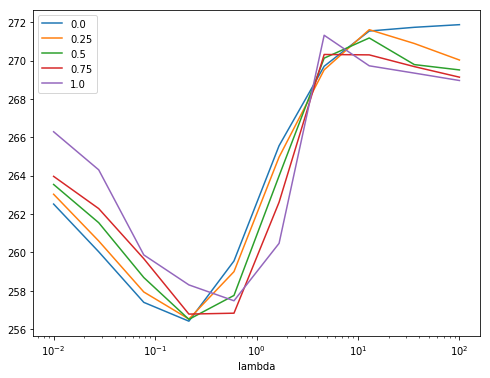

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, df in cv_metrics.groupby('l1_ratio'):
    df.plot(kind='line', x='lambda', y='mse_test', ax=ax, label=label, logx=True)
plt.legend()